In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
device = torch.device('cuda:2')

## Data location and metadata
  First step is to lcoate the data and load the associated metadata. Given the structure of the json file we transpose for ease of use

In [3]:
data_path = '/mnt/fs03/shared/datasets/deep_fake_detection_challenge/deepfake-detection-challenge/train_sample_videos'
df = pd.read_json('{}/metadata.json'.format(data_path)).transpose()

print(df.columns)
print(df.head)

Index(['label', 'split', 'original'], dtype='object')
<bound method NDFrame.head of                label  split        original
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
abarnvbtwb.mp4  REAL  train            None
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4
...              ...    ...             ...
etejaapnxh.mp4  FAKE  train  wtreibcmgm.mp4
etmcruaihe.mp4  FAKE  train  afoovlsmtx.mp4
etohcvnzbj.mp4  FAKE  train  bdnaqemxmr.mp4
eudeqjhdfd.mp4  REAL  train            None
eukvucdetx.mp4  FAKE  train  gjypopglvi.mp4

[400 rows x 3 columns]>


String labels are hard to use in ML, replace 'FAKE' = 1 and 'REAL' = 0 (Labels used in competition), and basic data validation

In [4]:
df['file'] = df.index
df.index = np.arange(len(df))
df.reset_index()
df['label'] = df['label'].map({'REAL' : 0, 'FAKE': 1})
n_real, n_fake = len(df[df['label'] == 0]), len(df[df['label'] == 1])
print('Set has {} real videos and {} fake'.format(n_real, n_fake))

Set has 77 real videos and 323 fake


# Highly imbalanced!!
  The dataset is highly imbalanced, with a ratio of roughly **4:1 fake:real**. 
  

![image](./images/imbalanced.png)

  A model that predicts that every video is fake would have **80% accuracy**!!!
  
A balanced training set for is essential to train a good ML model.  How should we balance the dataset?
- Add external data
- Sub-sampling
- Over-sampling  

For simplicity in this tutorial we will subsample the available fake data.  

### Lets investigate imbalance further
What is the source of the imbalance?  Does each real video have an associated fake? Multiple fakes? 

Text(0.5, 1.0, 'Number of fake videos associated to a real video')

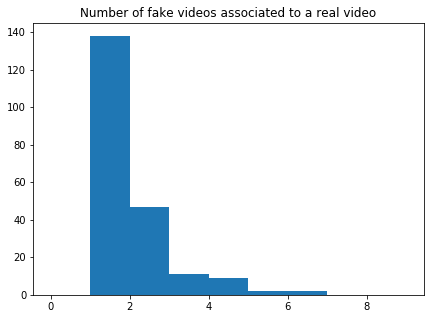

In [5]:
fake_per_real = []

for vid in df[df['label']==1]['original'].unique():
    fake_per_real.append(len(df[df['original'] == vid]))
fig = plt.figure(figsize = (7, 5))

plt.hist(fake_per_real, bins = [x for x in range(10)] )
plt.title('Number of fake videos associated to a real video')

Most real videos have a single associated fake, many have 2+.  

These videos are dangerous: for example if one original video has 7 fake videos predicting fake for that set would have high accuracy.

A first way to cull the fake datast is to remove all cases where there are 2 or more fake videos associated to a single real

In [48]:
real = df[df['label'] == 0].reset_index(drop=True)
fake = df[df['label'] == 1]
for original in fake['original'].unique():
    if len(fake[fake['original'] == original]) >= 2:
        fake = fake.drop(fake[fake['original'] == original].index)
fake = fake.reset_index(drop=True)
print('New length {}'.format(len(fake)))

New length 138


## Balancing dataset

We have removed roughly 1/3 of the entries from the fake dataset.  For the remainder, we can chose a random set of 77 fake videos 

In [7]:
fake = fake.sample(n=len(real)).reset_index(drop=True)

## Training/Validation split
When training a ML model it is useful to isolate a subset of the data to validate the result and test against overfitting.  To make sure both sets are balanced we can split them seperately and then merge

In [8]:
real_train = real.sample(frac=0.9)
real_val = real.drop(real_train.index)
fake_train = fake.sample(frac=0.9)
fake_val = fake.drop(fake_train.index)

train_df = pd.concat([real_train, fake_train]).reset_index(drop=True)
val_df = pd.concat([real_val, fake_val]).reset_index(drop=True)
print('Train/Val split sizes = {}/{}'.format(len(train_df), len(val_df)))

Train/Val split sizes = 138/16


## Preprocessing the data
  The videos are given im mp4 format.  Our first step will be to extract frames and audio from the individual videos to be used to train and validate our models.  The following diagram shows the rough idea behind pre-processing:
![img](./images/preprocessing.jpg)
### Video:
Extracting frames using opencv-python and isolate participant faces using BlazeFace face detection
- Extract first 10 frames evenly spaced from each video
- Use face detection to isolate top ranked face

We have provided two helper fucntions to: 

a) Extract frames from the videos (using [OpenCV](https://opencv.org/))

b) Tile video frames and detect faces in them (using [BlazeFace](https://arxiv.org/abs/1907.05047)).  


For more detail regarding the implementation please see the contents of the directory __helpers__

In [9]:
sys.path.insert(1, './BlazeFace/')
sys.path.insert(1, './helpers/')
from blazeface import BlazeFace
from read_video import VideoReader
from face_extract import FaceExtractor

In [10]:
video_reader = VideoReader()

### Lets test on an example

In [11]:
example = '{}/bnjcdrfuov.mp4'.format(data_path)
frames = video_reader.read_frames_at_indices(example, [x for x in range(4)])

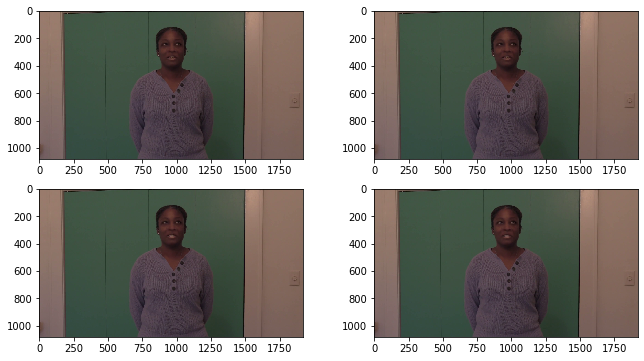

In [12]:
fig = plt.figure(figsize=(11, 6))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.imshow(frames[0][idx])


### Face Extraction
  For face edxtraction we leverage pytorch version of BlazeFace, and build a wrapper around it and our frame extractor 

In [13]:
sys.path.insert(1, './BlazeFace/')
from blazeface import BlazeFace

In [14]:
facedet = BlazeFace().to(device)
facedet.load_weights("./BlazeFace/blazeface.pth")
facedet.load_anchors("./BlazeFace/anchors.npy")
_ = facedet.train(False)
def video_read_fn(x): return video_reader.read_frames(
    x, num_frames=10)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [15]:
faces = face_extractor.process_video(example)
face_extractor.keep_only_best_face(faces)

### Some frames do not have detected faces

In [16]:
for idx, entry in enumerate(faces):
    if entry['faces'] == []:
        print(len(entry['faces']))
        faces.remove(entry)


10


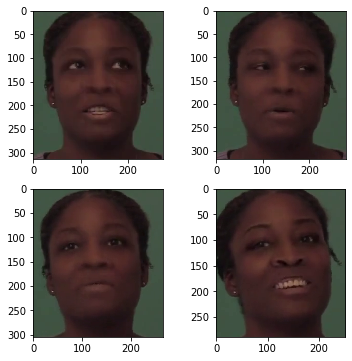

In [17]:
fig = plt.figure(figsize=(6, 6))
print(len(faces))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.imshow(faces[idx]['faces'][0])

### Resizing/padding images
Extracted frames can vary in size due to actor position, changes in pose, etc.  This is generally an issue when training a DL model when we usually expect data points to be of a fixed size.  Lets include some utility functions to resize and pad the images

In [18]:
import cv2
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

### ... and voila! 

10


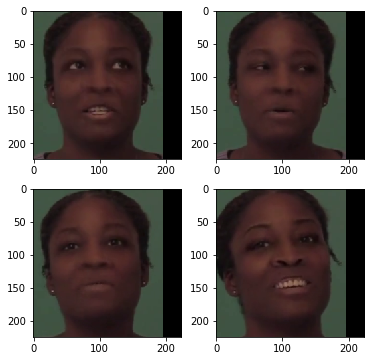

In [19]:
fig = plt.figure(figsize=(6, 6))
print(len(faces))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    img = isotropically_resize_image(faces[idx]['faces'][0], 224)
    plt.imshow(make_square_image(img))

### Real vs. Fake examples
As an exercise let us visualize a real, vs fake example

In [20]:
example = '{}/duycddgtrl.mp4'.format(data_path)
faces = face_extractor.process_video(example)
face_extractor.keep_only_best_face(faces)

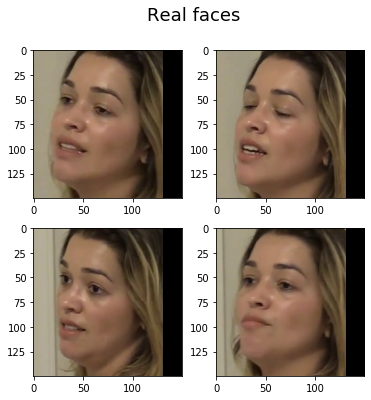

In [21]:
fig = plt.figure(figsize=(6, 6))
fig.suptitle('Real faces', fontsize=18)
for idx in range(4):
    resized_face = isotropically_resize_image(faces[idx]['faces'][0], 150)
    resized_face = make_square_image(resized_face)
    plt.subplot(2, 2, idx+1)
    plt.imshow(resized_face)

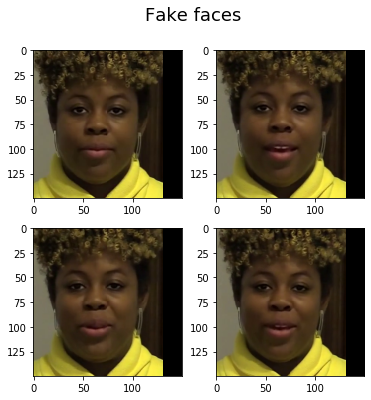

In [22]:
example = '{}/bydaidkpdp.mp4'.format(data_path)
faces = face_extractor.process_video(example)
face_extractor.keep_only_best_face(faces)
fig = plt.figure(figsize=(6, 6))
fig.suptitle('Fake faces', fontsize=18)
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    resized_face = isotropically_resize_image(faces[idx]['faces'][0], 150)
    resized_face = make_square_image(resized_face)
    plt.imshow(resized_face)

### Preprocess video
The next step is to preprocess the video.  Frame extraction is particularly time consuming so it makes sense to do this before training a model.  We will extract 10 frames from each video, in hopes of at least obtaiing 5 for training later

In [23]:
from tqdm import tqdm
from pathlib import Path
from PIL import Image

def preprocess_video(video_path, save_path, input_size=150):
    try:
        # Find the faces for N frames in the video.
        faces = face_extractor.process_video(video_path)

        # Only look at one face per frame.
        face_extractor.keep_only_best_face(faces)
        n = 0
        if len(faces) > 0:
            # If we found any faces, prepare them for the model   
            for frame_data in faces:
                if len(frame_data['faces']) == 0 :
                    continue
                for face in frame_data["faces"]:
                    # Resize to the model's required input size.
                    # We keep the aspect ratio intact and add zero
                    # padding if necessary.
                    resized_face = isotropically_resize_image(face, input_size)
                    resized_face = make_square_image(resized_face)
                    im = Image.fromarray(resized_face)
                    im.save('{}/frame_{}.png'.format(save_path, n))
                    n += 1
        return n
    except:
        return 0
    
def preprocess_set(dataset, save_path, input_size=150):
    
    meta = dataset.copy()
    meta['nframes'] = 0
    pbar = tqdm(total=len(meta))
    for idx in range(len(meta)):
        pbar.update(1)
        entry = dataset.iloc[idx]
        outdir = '{}/{}'.format(save_path, entry['file'])
        Path(outdir).mkdir(parents=True, exist_ok=True)
        
        nframes = preprocess_video('{}/{}'.format(data_path, entry['file']), 
                                   outdir, input_size)
        meta.loc[idx, 'nframes'] = nframes
        
    return meta
#     with ThreadPoolExecutor(max_workers=nworkers) as ex:
#         tqdm(ex.map(process_file, range(len(df))), total=len(df))
    
    

In [24]:
train_df = preprocess_set(train_df, './preprocessed')

100%|██████████| 138/138 [01:27<00:00,  1.58it/s]

In [25]:
val_df = preprocess_set(val_df, './preprocessed')


100%|██████████| 16/16 [00:09<00:00,  1.41it/s]

### ... while that runs let's recap
As of yet we have:

1. Loaded the metadata
2. Preliminary exploration of dataset: found it very imbalanced
3. Balanced the dataset
4. Defined train/validation splits
5. Extracted frames from videos, and faces from frames
6. Resized the faces to a standard shape
7. Prprocessed the dataset

![](https://media.giphy.com/media/l3q2umc327t2nzSOQ/giphy.gif)

### Preprocessed results
  Most videos have the required 10 frames, though some have as few as 0.  When laoding the data in taining/vvalidation, make sure that we have enough frames!

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 15.]),
 array([ 5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <a list of 10 Patch objects>)

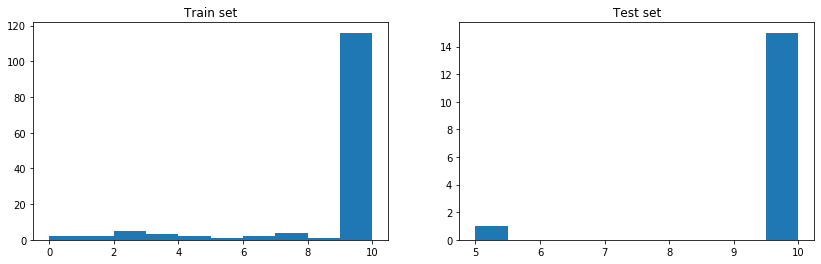

In [26]:
fig = plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.gca().title.set_text('Train set')
plt.hist(train_df['nframes'])
plt.subplot(1, 2, 2)
plt.gca().title.set_text('Test set')
plt.hist(val_df['nframes'])

In [27]:
train_df.to_csv('./preprocessed/train.csv')
val_df.to_csv('./preprocessed/val.csv')

In [28]:
train_df = pd.read_csv('./preprocessed/train.csv')
val_df = pd.read_csv('./preprocessed/val.csv')

## Pytorch dataset class
Now that we have a preprocessed dataset we will define the appropriate pytorch dataset class to load the data into our models for training.  Given the limited amount of data, we will:
- Leverage transfer learning (see trainig section)
- Use data augmentation on the loaded frames

In [29]:
from torch.utils.data import Dataset
from albumentations.augmentations.transforms import ShiftScaleRotate, HorizontalFlip, Normalize
from albumentations.augmentations.transforms import RandomBrightnessContrast, MotionBlur, Blur, GaussNoise, JpegCompression

In [30]:
from torchvision import transforms
import albumentations
class DFDC_Dataset(Dataset):
    """ DeepFake detection dataset
    """

    def __init__(self, df=None, data_path='', 
                 size=150, mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225], augment=True, frames=5,
                 stochastic=True):
        """ Dataset initialization
        Parameters
        ----------
        df : pd.DataFrame
            Dataframe with preprocessed data
        transform : torchvision.transforms
            Transformation operations for loaded images
        path : str
            Path to folder with the data
        frames : int
            Frames to load per video
        """
        assert df is not None, 'Missing dataframe for data'
        self.data_path = data_path
        self.frames = frames
        self.df = df[df['nframes'] >= frames]
        self.stochastic = stochastic
        addtl_img = {}
        for idx in range(frames):
            addtl_img['image{}'.format(idx)] = 'image'
        if augment:
            self.transform = albumentations.Compose([
                ShiftScaleRotate(p=0.3, scale_limit=0.25,
                                 border_mode=1, rotate_limit=15),
                HorizontalFlip(p=0.2),
                RandomBrightnessContrast(
                    p=0.3, brightness_limit=0.25, contrast_limit=0.5),
                MotionBlur(p=.2),
                GaussNoise(p=.2),
                JpegCompression(p=.2, quality_lower=50),
                Normalize(mean, std)
            ], additional_targets=addtl_img)
        else:
            self.transform = albumentations.Compose([
                Normalize(mean, std)
            ])
        self.resize = transforms.Resize((size, size))

    def __len__(self):
        """ Len of dataset
        Parameters
        ----------
        Returns
        -------
        length : int
            Dataset length
        """
        return len(self.df)

    def __getitem__(self, idx):
        """ Return dataset item
        Parameters
        ----------
        idx : int
            Item to retrieve
        Returns
        -------
        frames : torch.tensor
            Torch tensor with video frames size (1, n_frames, 3, h, w)
        lbls : torch.tensor
            Tensor with video lables (1=real, 0=fake)
        """
        entry = self.df.iloc[idx]
        if not self.stochastic:
            if entry['nframes']-self.frames <= 0:
                start = 0
        else:
            if entry['nframes'] == self.frames:
                start = 0
            else:
                start = np.random.randint(0, entry['nframes']-self.frames)
        to_pass = {}
        for idx in range(self.frames):
            f = '{}/{}/frame_{}.png'.format(self.data_path, entry['file'], start+idx)
            if idx == 0:
                to_pass['image'] = np.array(self.resize(Image.open(f)))
            else:
                to_pass['image{}'.format(idx)] = np.array(
                    self.resize(Image.open(f)))
        frames = self.transform(**to_pass)
        frames = np.stack([x for x in frames.values()])
        return torch.from_numpy(np.rollaxis(frames, 3, 1)), entry['label']

### Training/val datasets and dataloaders

In [31]:
from torch.utils.data import DataLoader
trainset = DFDC_Dataset(df=train_df, 
                        data_path='/home/mlomnitz/mlomnitz/IEEE_tutorial/preprocessed',
                        frames=1)
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=16)
valset = DFDC_Dataset(df=val_df, 
                      data_path='/home/mlomnitz/mlomnitz/IEEE_tutorial/preprocessed',
                      frames=1, augment=False)
valloader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=16)

### Test the dataloader
 - imgs shape: (batch_size, nframes, channels, height, width)
 - labels: (batch_size)

In [32]:
imgs, labels = iter(trainloader).next()
print(imgs.shape, labels.shape)

torch.Size([16, 1, 3, 150, 150]) torch.Size([16])


### Defining a basic model
Since the dataset is small, a first iteration on training a model could leverage transfer learning from a similar domain.  As an example, we can use pretrained ImageNet models from torchvision. 

Lets load a pretrained ResNet 

In [33]:
from torchvision import models
resnet = models.resnet50(pretrained=True)

In [34]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Changing architecture to suit our problem
ImageNet included 1000 different categories, we need to simply classify between real and fake.  We can modify the pretrained network by replacing th elast, fully connected network with one that suits our problem

In [35]:
import torch.nn as nn
resnet.fc = nn.Sequential(
    nn.Linear(in_features = 2048, out_features=512),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=512, out_features=1),
    nn.Sigmoid()
)

### Model training
To get ready for model training we will define a loss function, optimizer and then write our training/validations routines.  

We will be using Adam optimizer with pretty standard hyperparameters.

We will be sing Binary Cross Entropy for our cost function

In [36]:
import torch.optim as optim
parameters = list(resnet.parameters())
optimizer = optim.Adam(parameters, lr=0.0001, betas=(
    0.5, 0.999), weight_decay=0.)
loss = nn.BCELoss()

### Utility class
Define a utility class to track the average loss over an epoch

In [37]:
class AverageMeter(object):
    """
    Computes and stores the average and current value.
    """

    def __init__(self):
        """ Initialize objects and reset for safety
        Parameters
        ----------
        Returns
        -------
        """
        self.reset()

    def reset(self):
        """ Resets the meter values if being re-used
        Parameters
        ----------
        Returns
        -------
        """
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """ Update meter values give current value and batchsize
        Parameters
        ----------
        val : float
            Value fo metric being tracked
        n : int
            Batch size
        Returns
        -------
        """
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [38]:
def train(model=None, dataloader=None, testloader=None, optim=None,
          criterion=nn.CrossEntropyLoss(), n_epochs=0,
          device='cuda:0' if torch.cuda.is_available() else 'cpu'):
    """ Training routing for deep fake detector
    Parameters
    ----------
    model : torch.Module
        Deep fake detector model
    dataloader : torch.utils.data.DataLoader
        Training dataset
    optim : torch.optim
        Optimizer for pytorch model
    scheduler : torch.optim.lr_scheduler
        Optional learning rate scheduler for the optimizer
    criterion : torch.nn.Module
        Objective function for optimization
    losses : list
        List to hold the lossses over each mini-batch
    averages : list
        List to hold the average loss over each epoch
    n_epochs : int
        Number of epochs for training
    device : str
        Device to run training procedure
    verbose : bool
        Verbose switch to print losses at each mini-batch
    """
    device = torch.device(device)
    model = model.to(device)
    meter = AverageMeter()
    train_losses = []
    test_losses = []
    accuracy = []
    pbar = tqdm(total=len(dataloader))
    for epoch in range(n_epochs):
        model.train()
        for i_batch, batch in enumerate(dataloader):
            frames, lbls = batch
            frames, lbls = frames.to(device), lbls.float().to(device)
            frames = frames.squeeze(1) # Shape is now (bs, channels, H, W)
            optim.zero_grad()
            # Establish shared key
            predictions = model(frames).reshape(lbls.shape[0])
            # print(predictions.shape)
            # print(predictions, lbls)
            loss = criterion(predictions, lbls)
            loss.backward()
            optim.step()
            meter.update(loss.item(), frames.shape[0])

            pbar.update(1)
        acc, v_loss = test(dataloader=testloader, model=model,
                           criterion=criterion, device=device)
        train_losses.append(meter.avg)
        test_losses.append(v_loss)
        accuracy.append(acc)
        print('Losses -- Train: {}  Test: {}'.format(meter.avg, v_loss))
        meter.reset()
        pbar.refresh()
        pbar.reset()

    pbar.close()
    return train_losses, test_losses, accuracy

def test(dataloader, model, criterion, device):
    """ Test deep fake detector
    Parameters
    ----------
    dataloader : torch.utils.data.DataLoader
        Dataloader used for evaluation
    model : torch.Module
        Pytorch module to evaluate
    crriterion : torch.nn.Module
        Objective function used in training
    device : str
        Device to run eval
    Returns
    -------
    accuracy : float
        Model accuracy over evaluation set
    """
    device = torch.device(device)
    model.to(device)
    model.eval()
    correct = 0
    loss = 0
    total = 0
    print('------------ Validating performance')
    for idx, batch in enumerate(dataloader):
        frames, lbls = batch
        frames, lbls = frames.to(device), lbls.float().to(device)
        frames = frames.squeeze(1)
        with torch.no_grad():
            predictions = model(frames).reshape(frames.shape[0])
            correct += (torch.round(predictions).detach()
                        == lbls).sum().cpu().numpy()
        total += frames.shape[0]
        loss += (lbls.shape[0]) * \
            (criterion(predictions, lbls).detach().cpu().item())
    return 100.*correct/total, loss/total

In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_loss, val_loss, accuracy = train(model=resnet, dataloader=trainloader, testloader=valloader,
      optim=optimizer, criterion=loss, n_epochs=10, device=device)



  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:01<00:10,  1.37s/it]

 33%|███▎      | 3/9 [00:01<00:05,  1.01it/s]

 56%|█████▌    | 5/9 [00:01<00:02,  1.40it/s]

 78%|███████▊  | 7/9 [00:01<00:01,  1.91it/s]

100%|██████████| 9/9 [00:01<00:00,  2.59it/s]

------------ Validating performance




100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

  0%|          | 0/9 [00:00<00:03,  2.59it/s]

Losses -- Train: 0.7221732385018292  Test: 0.7750468254089355




 22%|██▏       | 2/9 [00:01<00:03,  2.16it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.88it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.76it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.77it/s]

------------ Validating performance




100%|██████████| 9/9 [00:03<00:00,  4.77it/s]

  0%|          | 0/9 [00:00<00:01,  4.77it/s]

Losses -- Train: 0.6564751758294947  Test: 0.765486478805542




 22%|██▏       | 2/9 [00:01<00:02,  2.96it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.84it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.86it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.97it/s]

------------ Validating performance




100%|██████████| 9/9 [00:03<00:00,  5.97it/s]

  0%|          | 0/9 [00:00<00:01,  5.97it/s]

Losses -- Train: 0.5978197209975299  Test: 0.9288104772567749




 22%|██▏       | 2/9 [00:01<00:02,  3.21it/s]

 44%|████▍     | 4/9 [00:01<00:01,  4.12it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  5.18it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.29it/s]

------------ Validating performance




100%|██████████| 9/9 [00:03<00:00,  6.29it/s]

  0%|          | 0/9 [00:00<00:01,  6.29it/s]

Losses -- Train: 0.49323484476874857  Test: 1.1833977699279785




 22%|██▏       | 2/9 [00:01<00:02,  3.26it/s]

 44%|████▍     | 4/9 [00:01<00:01,  4.17it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  5.19it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.32it/s]

------------ Validating performance




100%|██████████| 9/9 [00:03<00:00,  6.32it/s]

  0%|          | 0/9 [00:00<00:01,  6.32it/s]

Losses -- Train: 0.568408373524161  Test: 0.9113483428955078




 22%|██▏       | 2/9 [00:01<00:02,  3.30it/s]

 44%|████▍     | 4/9 [00:01<00:01,  4.24it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  5.30it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.44it/s]

------------ Validating performance




100%|██████████| 9/9 [00:03<00:00,  6.44it/s]

  0%|          | 0/9 [00:00<00:01,  6.44it/s]

Losses -- Train: 0.45398911658455343  Test: 0.9999533891677856




 22%|██▏       | 2/9 [00:01<00:02,  3.32it/s]

 44%|████▍     | 4/9 [00:01<00:01,  4.26it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  5.33it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.47it/s]

------------ Validating performance




100%|██████████| 9/9 [00:03<00:00,  6.47it/s]

  0%|          | 0/9 [00:00<00:01,  6.47it/s]

Losses -- Train: 0.4050840595189263  Test: 1.0551161766052246




 22%|██▏       | 2/9 [00:01<00:02,  3.30it/s]

 44%|████▍     | 4/9 [00:01<00:01,  4.24it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  5.30it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.43it/s]

------------ Validating performance




100%|██████████| 9/9 [00:03<00:00,  6.43it/s]

  0%|          | 0/9 [00:00<00:01,  6.43it/s]

Losses -- Train: 0.375940261518254  Test: 1.4488461017608643




 22%|██▏       | 2/9 [00:01<00:02,  3.31it/s]

 44%|████▍     | 4/9 [00:01<00:01,  4.26it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  5.31it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.44it/s]

------------ Validating performance




100%|██████████| 9/9 [00:03<00:00,  6.44it/s]

  0%|          | 0/9 [00:00<00:01,  6.44it/s]

Losses -- Train: 0.3671841358437258  Test: 1.2368886470794678




 22%|██▏       | 2/9 [00:01<00:02,  3.31it/s]

 44%|████▍     | 4/9 [00:01<00:01,  4.25it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  5.29it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  6.42it/s]

------------ Validating performance




100%|██████████| 9/9 [00:03<00:00,  6.42it/s]

  0%|          | 0/9 [00:00<?, ?it/s]        

Losses -- Train: 0.5455071470316719  Test: 1.2569044828414917


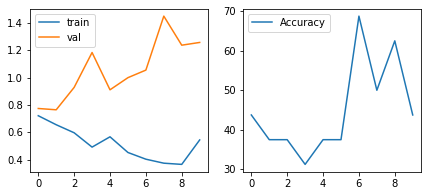

In [40]:
fig = plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Accuracy')
plt.legend()

### Overfitting
  The model seems to be overfitting to the data, which is not surprising given the small amount of trianing data used.  In practice we should introduce a regularization term, or more data augmentation.  FOr the purpose of this tutorial we will move on to more complex models

## Video model
  Using our trained, single frame detector we will build a model that takes information from 5 frames to predict if the video is real of fake

In [41]:
test = list(resnet.children())[:-2] + list(resnet.fc.children())[:-2]
print(test)

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [42]:
import torch.nn.functional as F
class LSTM(nn.Module):
    def __init__(self, latent_dim, num_layers, hidden_dim, bidirectional):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers,
                            batch_first=True, bidirectional=bidirectional)
        self.hidden_state = None

    def reset_hidden_state(self):
        self.hidden_state = None

    def forward(self, x):
        x, self.hidden_state = self.lstm(x, self.hidden_state)
        return x
    
class ConvLSTM(nn.Module):
    """ Convolitional LSTM model for video predictions
    """

    def __init__(
        self, encoder=None, lstm_layers=1, latent_dim=512,
        hidden_dim=512, bidirectional=True, attention=True
    ):
        """ Inintialization
        Parameters
        ----------
        num_classes : int
            Number of output classes
        latent_dim : int
            Latent dimension for embeddings fed into LSTMs
        lstm_layers : int
            Number of lstm layers to use in model
        hidden_dim : int
            Hidden kayer dimension in final prediction block
        bidirectional : bool
            Bi/Unidrectional switch
        attention : bool
            Attention block switch
        encoder : str
            Encoder architecture
        Returns
        -------
        """
        super(ConvLSTM, self).__init__()
        assert encoder, 'Need to input an encoder' 
        self.encoder = nn.Sequential(*list(encoder.children())[:-1])
        self.features = nn.Sequential(*list(encoder.fc.children())[:-2])
        self.lstm = LSTM(latent_dim, lstm_layers, hidden_dim, bidirectional)
        self.output_layers = nn.Sequential(
            nn.Linear(
                2 * hidden_dim if bidirectional else hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim, momentum=0.01),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            # nn.Softmax(dim=-1),
            # nn.Sigmoid()
        )
        self.attention = attention
        self.attention_layer = nn.Linear(
            2 * hidden_dim if bidirectional else hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """ Forward pass
        Parameters
        ----------
        x : torch.tensor
            Tensor with video frames, expected size (bs, n_frames, c, h, w)
        Returns
        -------
        x : torch.tensor
            Processed torch data
        """
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        x = self.encoder(x)
        x = x.reshape(batch_size*seq_length, -1)
        x = self.features(x)
        x = x.view(batch_size, seq_length, -1)
        x = self.lstm(x)
        if self.attention:
            attention_w = F.softmax(
                self.attention_layer(x).squeeze(-1), dim=-1)
            x = torch.sum(attention_w.unsqueeze(-1) * x, dim=1)
        else:
            x = x[:, -1]
        x = self.output_layers(x)

        x = self.sigmoid(x)
        return x.view(x.shape[0])


In [43]:
resnet_lstm = ConvLSTM(encoder=resnet)

In [44]:
del trainset, valset, trainloader, valloader
trainset = DFDC_Dataset(df=train_df, 
                        data_path='/home/mlomnitz/mlomnitz/IEEE_tutorial/preprocessed',
                        frames=5)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=8)
valset = DFDC_Dataset(df=val_df, 
                      data_path='/home/mlomnitz/mlomnitz/IEEE_tutorial/preprocessed',
                      frames=5, augment=False)
valloader = DataLoader(valset, batch_size=8, shuffle=False, num_workers=8)

In [45]:
def test_multiframe(dataloader, model, criterion, device):
    """ Test deep fake detector
    Parameters
    ----------
    dataloader : torch.utils.data.DataLoader
        Dataloader used for evaluation
    model : torch.Module
        Pytorch module to evaluate
    crriterion : torch.nn.Module
        Objective function used in training
    device : str
        Device to run eval
    Returns
    -------
    accuracy : float
        Model accuracy over evaluation set
    """
    device = torch.device(device)
    model.to(device)
    model.eval()
    correct = 0
    loss = 0
    total = 0
    print('------------ Validating performance')
    for idx, batch in enumerate(dataloader):
        frames, lbls = batch
        frames, lbls = frames.to(device), lbls.float().to(device)
        model.lstm.reset_hidden_state()
        with torch.no_grad():
            predictions = model(frames).reshape(frames.shape[0])
            correct += (torch.round(predictions).detach()
                        == lbls).sum().cpu().numpy()
        total += frames.shape[0]
        loss += (lbls.shape[0]) * \
            (criterion(predictions, lbls).detach().cpu().item())
    return 100.*correct/total, loss/total

def train_multiframe(model=None, dataloader=None, testloader=None, optim=None,
                      criterion=nn.CrossEntropyLoss(), n_epochs=0, device='cpu'):
    """ Training routing for deep fake detector
    Parameters
    ----------
    model : torch.Module
        Deep fake detector model
    dataloader : torch.utils.data.DataLoader
        Training dataset
    optim : torch.optim
        Optimizer for pytorch model
    scheduler : torch.optim.lr_scheduler
        Optional learning rate scheduler for the optimizer
    criterion : torch.nn.Module
        Objective function for optimization
    losses : list
        List to hold the lossses over each mini-batch
    averages : list
        List to hold the average loss over each epoch
    n_epochs : int
        Number of epochs for training
    device : str
        Device to run training procedure
    verbose : bool
        Verbose switch to print losses at each mini-batch
    """
    device = torch.device(device)
    model = model.to(device)
    meter = AverageMeter()
    train_losses = []
    test_losses = []
    accuracy = []
    pbar = tqdm(total=len(dataloader))
    for epoch in range(n_epochs):
        model.train()
        for i_batch, batch in enumerate(dataloader):
            frames, lbls = batch
            frames, lbls = frames.to(device), lbls.float().to(device)
            optim.zero_grad()
            model.lstm.reset_hidden_state()
            # Establish shared key
            predictions = model(frames).reshape(lbls.shape[0])
            # print(predictions.shape)
            # print(predictions, lbls)
            loss = criterion(predictions, lbls)
            loss.backward()
            optim.step()
            meter.update(loss.item(), frames.shape[0])

            pbar.update(1)
        acc, v_loss = test_multiframe(dataloader=testloader, model=model,
                           criterion=criterion, device=device)
        train_losses.append(meter.avg)
        test_losses.append(v_loss)
        accuracy.append(acc)
        print('Losses -- Train: {}  Test: {}'.format(meter.avg, v_loss))
        meter.reset()
        pbar.refresh()
        pbar.reset()

    pbar.close()
    return train_losses, test_losses, accuracy

In [46]:
train_loss, val_loss, accuracy = train_multiframe(model=resnet_lstm, 
                                                  dataloader=trainloader,
                                                  testloader=valloader,
                                                  optim=optimizer, 
                                                  criterion=loss, 
                                                  n_epochs=10, 
                                                  device=device)



  0%|          | 0/16 [00:00<?, ?it/s]

  6%|▋         | 1/16 [00:00<00:11,  1.25it/s]

 12%|█▎        | 2/16 [00:00<00:08,  1.67it/s]

 19%|█▉        | 3/16 [00:01<00:05,  2.17it/s]

 25%|██▌       | 4/16 [00:01<00:04,  2.76it/s]

 31%|███▏      | 5/16 [00:01<00:03,  3.39it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.06it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.71it/s]

 50%|█████     | 8/16 [00:01<00:01,  5.30it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  5.73it/s]

 62%|██████▎   | 10/16 [00:02<00:00,  6.16it/s]

 69%|██████▉   | 11/16 [00:02<00:00,  6.52it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  6.78it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  6.94it/s]

 88%|████████▊ | 14/16 [00:02<00:00,  7.10it/s]

 94%|█████████▍| 15/16 [00:02<00:00,  7.19it/s]

------------ Validating performance




100%|██████████| 16/16 [00:03<00:00,  7.19it/s]

  0%|          | 0/16 [00:00<00:02,  7.19it/s] 

Losses -- Train: 0.46934789419174194  Test: 0.6941949725151062




  6%|▋         | 1/16 [00:00<00:05,  2.99it/s]

 12%|█▎        | 2/16 [00:00<00:03,  3.64it/s]

 19%|█▉        | 3/16 [00:01<00:03,  4.27it/s]

 25%|██▌       | 4/16 [00:01<00:02,  4.91it/s]

 31%|███▏      | 5/16 [00:01<00:02,  5.45it/s]

 38%|███▊      | 6/16 [00:01<00:01,  5.93it/s]

 44%|████▍     | 7/16 [00:01<00:01,  6.33it/s]

 50%|█████     | 8/16 [00:01<00:01,  6.64it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  6.83it/s]

 62%|██████▎   | 10/16 [00:02<00:00,  6.96it/s]

 69%|██████▉   | 11/16 [00:02<00:00,  7.06it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  7.19it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  7.25it/s]

 88%|████████▊ | 14/16 [00:02<00:00,  7.33it/s]

 94%|█████████▍| 15/16 [00:02<00:00,  7.37it/s]

------------ Validating performance




100%|██████████| 16/16 [00:03<00:00,  7.37it/s]

  0%|          | 0/16 [00:00<00:02,  7.37it/s] 

Losses -- Train: 0.5542018115520477  Test: 0.7011155188083649




  6%|▋         | 1/16 [00:00<00:05,  2.84it/s]

 12%|█▎        | 2/16 [00:00<00:04,  3.46it/s]

 19%|█▉        | 3/16 [00:01<00:03,  4.11it/s]

 25%|██▌       | 4/16 [00:01<00:02,  4.75it/s]

 31%|███▏      | 5/16 [00:01<00:02,  5.34it/s]

 38%|███▊      | 6/16 [00:01<00:01,  5.84it/s]

 44%|████▍     | 7/16 [00:01<00:01,  6.23it/s]

 50%|█████     | 8/16 [00:01<00:01,  6.56it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  6.77it/s]

 62%|██████▎   | 10/16 [00:02<00:00,  6.89it/s]

 69%|██████▉   | 11/16 [00:02<00:00,  7.06it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  7.18it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  7.28it/s]

 88%|████████▊ | 14/16 [00:02<00:00,  7.31it/s]

 94%|█████████▍| 15/16 [00:02<00:00,  7.36it/s]

------------ Validating performance




100%|██████████| 16/16 [00:03<00:00,  7.36it/s]

  0%|          | 0/16 [00:00<00:02,  7.36it/s] 

Losses -- Train: 0.4025325486736913  Test: 0.6908809542655945




  6%|▋         | 1/16 [00:00<00:04,  3.03it/s]

 12%|█▎        | 2/16 [00:00<00:03,  3.67it/s]

 19%|█▉        | 3/16 [00:01<00:03,  4.31it/s]

 25%|██▌       | 4/16 [00:01<00:02,  4.94it/s]

 31%|███▏      | 5/16 [00:01<00:02,  5.49it/s]

 38%|███▊      | 6/16 [00:01<00:01,  5.98it/s]

 44%|████▍     | 7/16 [00:01<00:01,  6.35it/s]

 50%|█████     | 8/16 [00:01<00:01,  6.68it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  6.84it/s]

 62%|██████▎   | 10/16 [00:01<00:00,  7.04it/s]

 69%|██████▉   | 11/16 [00:02<00:00,  7.19it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  7.25it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  7.32it/s]

 88%|████████▊ | 14/16 [00:02<00:00,  7.39it/s]

 94%|█████████▍| 15/16 [00:02<00:00,  7.40it/s]

------------ Validating performance




100%|██████████| 16/16 [00:03<00:00,  7.40it/s]

  0%|          | 0/16 [00:00<00:02,  7.40it/s] 

Losses -- Train: 0.35644821197755877  Test: 0.6902815699577332




  6%|▋         | 1/16 [00:00<00:04,  3.02it/s]

 12%|█▎        | 2/16 [00:00<00:03,  3.64it/s]

 19%|█▉        | 3/16 [00:01<00:03,  4.30it/s]

 25%|██▌       | 4/16 [00:01<00:02,  4.93it/s]

 31%|███▏      | 5/16 [00:01<00:02,  5.50it/s]

 38%|███▊      | 6/16 [00:01<00:01,  5.99it/s]

 44%|████▍     | 7/16 [00:01<00:01,  6.39it/s]

 50%|█████     | 8/16 [00:01<00:01,  6.69it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  6.88it/s]

 62%|██████▎   | 10/16 [00:02<00:00,  7.02it/s]

 69%|██████▉   | 11/16 [00:02<00:00,  7.15it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  7.21it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  7.28it/s]

 88%|████████▊ | 14/16 [00:02<00:00,  7.34it/s]

 94%|█████████▍| 15/16 [00:02<00:00,  7.39it/s]

------------ Validating performance




100%|██████████| 16/16 [00:03<00:00,  7.39it/s]

  0%|          | 0/16 [00:00<00:02,  7.39it/s] 

Losses -- Train: 0.49857533458740483  Test: 0.6878789961338043




  6%|▋         | 1/16 [00:00<00:04,  3.02it/s]

 12%|█▎        | 2/16 [00:00<00:03,  3.65it/s]

 19%|█▉        | 3/16 [00:01<00:03,  4.31it/s]

 25%|██▌       | 4/16 [00:01<00:02,  4.94it/s]

 31%|███▏      | 5/16 [00:01<00:01,  5.51it/s]

 38%|███▊      | 6/16 [00:01<00:01,  6.00it/s]

 44%|████▍     | 7/16 [00:01<00:01,  6.38it/s]

 50%|█████     | 8/16 [00:01<00:01,  6.68it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  6.83it/s]

 62%|██████▎   | 10/16 [00:02<00:00,  7.00it/s]

 69%|██████▉   | 11/16 [00:02<00:00,  7.14it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  7.24it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  7.32it/s]

 88%|████████▊ | 14/16 [00:02<00:00,  7.39it/s]

 94%|█████████▍| 15/16 [00:02<00:00,  7.44it/s]

------------ Validating performance




100%|██████████| 16/16 [00:03<00:00,  7.44it/s]

  0%|          | 0/16 [00:00<00:02,  7.44it/s] 

Losses -- Train: 0.26815040938315854  Test: 0.6921519339084625




  6%|▋         | 1/16 [00:00<00:04,  3.03it/s]

 12%|█▎        | 2/16 [00:00<00:03,  3.67it/s]

 19%|█▉        | 3/16 [00:01<00:03,  4.32it/s]

 25%|██▌       | 4/16 [00:01<00:02,  4.96it/s]

 31%|███▏      | 5/16 [00:01<00:01,  5.51it/s]

 38%|███▊      | 6/16 [00:01<00:01,  5.99it/s]

 44%|████▍     | 7/16 [00:01<00:01,  6.38it/s]

 50%|█████     | 8/16 [00:01<00:01,  6.69it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  6.80it/s]

 62%|██████▎   | 10/16 [00:02<00:00,  6.98it/s]

 69%|██████▉   | 11/16 [00:02<00:00,  7.10it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  7.21it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  7.27it/s]

 88%|████████▊ | 14/16 [00:02<00:00,  7.33it/s]

 94%|█████████▍| 15/16 [00:02<00:00,  7.37it/s]

------------ Validating performance




100%|██████████| 16/16 [00:03<00:00,  7.37it/s]

  0%|          | 0/16 [00:00<00:02,  7.37it/s] 

Losses -- Train: 0.3179375058220279  Test: 0.6876311898231506




  6%|▋         | 1/16 [00:00<00:04,  3.04it/s]

 12%|█▎        | 2/16 [00:00<00:03,  3.67it/s]

 19%|█▉        | 3/16 [00:01<00:02,  4.33it/s]

 25%|██▌       | 4/16 [00:01<00:02,  4.96it/s]

 31%|███▏      | 5/16 [00:01<00:02,  5.41it/s]

 38%|███▊      | 6/16 [00:01<00:01,  5.91it/s]

 44%|████▍     | 7/16 [00:01<00:01,  6.29it/s]

 50%|█████     | 8/16 [00:01<00:01,  6.61it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  6.80it/s]

 62%|██████▎   | 10/16 [00:02<00:00,  6.97it/s]

 69%|██████▉   | 11/16 [00:02<00:00,  7.05it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  7.18it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  7.27it/s]

 88%|████████▊ | 14/16 [00:02<00:00,  7.31it/s]

 94%|█████████▍| 15/16 [00:02<00:00,  7.32it/s]

------------ Validating performance




100%|██████████| 16/16 [00:04<00:00,  7.32it/s]

  0%|          | 0/16 [00:00<00:02,  7.32it/s] 

Losses -- Train: 0.3161762981645523  Test: 0.6920498609542847




  6%|▋         | 1/16 [00:00<00:04,  3.01it/s]

 12%|█▎        | 2/16 [00:00<00:03,  3.66it/s]

 19%|█▉        | 3/16 [00:01<00:03,  4.30it/s]

 25%|██▌       | 4/16 [00:01<00:02,  4.93it/s]

 31%|███▏      | 5/16 [00:01<00:02,  5.48it/s]

 38%|███▊      | 6/16 [00:01<00:01,  5.94it/s]

 44%|████▍     | 7/16 [00:01<00:01,  6.32it/s]

 50%|█████     | 8/16 [00:01<00:01,  6.63it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  6.78it/s]

 62%|██████▎   | 10/16 [00:02<00:00,  6.98it/s]

 69%|██████▉   | 11/16 [00:02<00:00,  7.07it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  7.17it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  7.27it/s]

 88%|████████▊ | 14/16 [00:02<00:00,  7.29it/s]

 94%|█████████▍| 15/16 [00:02<00:00,  7.33it/s]

------------ Validating performance




100%|██████████| 16/16 [00:04<00:00,  7.33it/s]

  0%|          | 0/16 [00:00<00:02,  7.33it/s] 

Losses -- Train: 0.40404053801490414  Test: 0.6913361847400665




  6%|▋         | 1/16 [00:00<00:05,  3.00it/s]

 12%|█▎        | 2/16 [00:00<00:03,  3.63it/s]

 19%|█▉        | 3/16 [00:01<00:03,  4.28it/s]

 25%|██▌       | 4/16 [00:01<00:02,  4.87it/s]

 31%|███▏      | 5/16 [00:01<00:02,  5.44it/s]

 38%|███▊      | 6/16 [00:01<00:01,  5.92it/s]

 44%|████▍     | 7/16 [00:01<00:01,  6.29it/s]

 50%|█████     | 8/16 [00:01<00:01,  6.59it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  6.73it/s]

 62%|██████▎   | 10/16 [00:02<00:00,  6.89it/s]

 69%|██████▉   | 11/16 [00:02<00:00,  7.02it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  7.09it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  7.20it/s]

 88%|████████▊ | 14/16 [00:02<00:00,  7.28it/s]

 94%|█████████▍| 15/16 [00:02<00:00,  7.32it/s]

------------ Validating performance




100%|██████████| 16/16 [00:03<00:00,  7.32it/s]

  0%|          | 0/16 [00:00<?, ?it/s]         

Losses -- Train: 0.31774943225806757  Test: 0.692653477191925


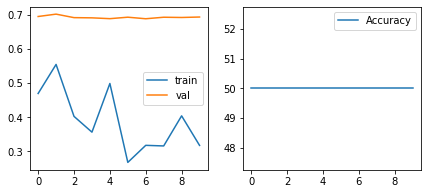

In [47]:
fig = plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Accuracy')
plt.legend()

### ...the end of second half
In this second half you have:

1. Defined a pytorch Dataset class and succesfully loaded the data usinga. DataLoader
2. Loaded a pretrained ImageNet benchmark model ResNet
3. Applied transfer learning to train the model on our deep fake detection dataset
4. Built a recurrent neural network around our trained resnet to detect deep fakes on a series of frames from each video
5. Validated the performance of your models agains the validation set

![](https://media.giphy.com/media/l4FAPaGGeB7D1LfIA/giphy.gif)